# 1. Before calling snps, we need to filter the data more. 
## First identify sites with low mappability and exclude them from snps


In [ ]:
gem-indexer -i /local/home/sarahgw/references/Myotis_lucifugus.Myoluc2.0.dna_sm.toplevel.fas -o /local/home/sarahgw/references/Myotis_lucifugus.Myoluc2.0

In [ ]:
gem-mappability -I /local/home/sarahgw/references/Myotis_lucifugus.Myoluc2.0.gem -l 140 -o /local/home/sarahgw/WGS/QC/Map -T 20

In [ ]:
gem-2-wig -i Map.mappability -I ~/references/Myotis_lucifugus.Myoluc2.0.gem -o Map

In [1]:
!head /local/home/sarahgw/WGS/QC/Map.wig

variableStep	chrom=GL429767 dna_sm	span=4317
1	1
variableStep	chrom=GL429767 dna_sm	span=5
4318	0.5
variableStep	chrom=GL429767 dna_sm
4323	0.0771517
4324	0.133631
4325	0.5
4326	0.0771517
variableStep	chrom=GL429767 dna_sm	span=6


Turn this wig file into a filter file for angsd. 

In [28]:
f=open('/local/home/sarahgw/WGS/QC/Map.wig', 'r')
o=open('/local/home/sarahgw/WGS/QC/All_mylu_Map1.txt', 'w')

line = " "
while True:
    line = f.readline()
    if not line:
        break
        
    if line.startswith("variableStep"):
        desc = line.split()
        chrom = desc[1].split('=')[1]
        span = None if 'span' not in desc[-1] else int(desc[-1].split('=')[1])
    else:
        data = line.split()
        val = int(data[0])
        if float(data[1]) == 1:
            if span:
                newline = "{}:{}-{}\n".format(chrom, val, span+val)
            else:
                newline = "{}:{}\n".format(chrom, val)
            o.write(newline)

f.close()
o.close()

In [15]:
!head -n 1 /local/home/sarahgw/WGS/QC/All_mylu_Map1.txt

GL429767:1-4318


In [9]:
f=open('/local/home/sarahgw/WGS/QC/All_mylu_Map1.txt', 'r')
total=0
for line in f:
    chrom=line.split(':')
    data=chrom[1]
    if '-' not in data :
        num=1
    else: 
        sub=data.split('-')
        num=int(sub[1])-int(sub[0])
    total+=num
total

1739971618

1,739,971,618
so 1.7 GB are mappable score of 1. out of 2.2

Limit depth calculation to mappable regions

In [ ]:
/local/home/sarahgw/angsd/angsd/angsd -b /local/home/sarahgw/WGS/Sequences/filelists/All_Mylu.filelist -rf /local/home/sarahgw/WGS/QC/All_mylu_Map1.txt -minMapQ 30 -minQ 20 -doCounts 1 -doDepth 1 -maxDepth 1000 -out /local/home/sarahgw/WGS/QC/All_mylu_depth_summary1000 -P 20

Make plot using ryan's code

(0, 101)

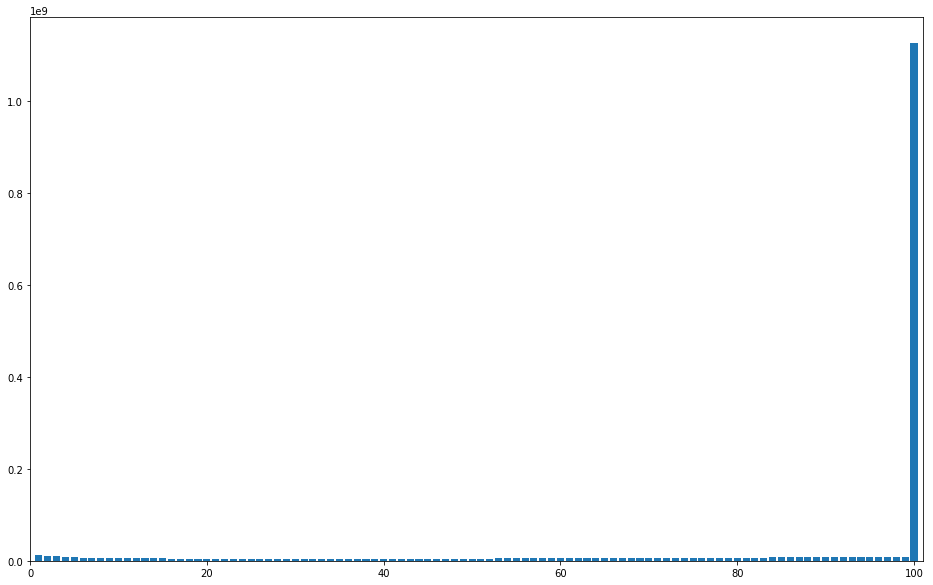

In [8]:
import numpy as np
import matplotlib.pyplot as plt
depth = np.loadtxt('/local/home/sarahgw/WGS/QC/All_mylu_depth_summary.depthGlobal', dtype='int')
fix, ax = plt.subplots(1, figsize = (16, 10))
ax.bar(range(len(depth)), depth, align = 'center')
plt.xlim(0, 101)

In [ ]:
for file in $ls; do samtools index $file; done

look to see if snps of interest are in regions of low mappability (No)

# 2. Redoing SNP calling 
limit to areas with high scores of mappability, limit depth to 1320 (10x depth in every individual)

In [ ]:
~/angsd/angsd/angsd -b /local/home/sarahgw/WGS/Sequences/filelists/All_Mylu.filelist -GL 1 -doMajorMinor 1 -doMaf 1 -doCounts 1 -minQ 20 -minMapQ 30 -SNP_pval 1e-6 -minInd 68 -setMaxDepth 1320 -rf /local/home/sarahgw/WGS/QC/All_mylu_Map1.txt -out /local/home/sarahgw/WGS/SNPS/All_mylu/snps/All_mylu_snps_filt -P 20

## Calculate genotype likelihoods in beagle format for input into pcangsd

In [ ]:
~/angsd/angsd/angsd -b /local/home/sarahgw/WGS/Sequences/filelists/All_Mylu.filelist -GL 1 -doGlf 2 -doMajorMinor 1 -doMaf 1 -doCounts 1 -minQ 20 -minMapQ 30 -SNP_pval 1e-6 -minInd 68 -setMaxDepth 1320 -rf /local/home/sarahgw/WGS/QC/All_mylu_Map1.txt -out /local/home/sarahgw/WGS/SNPS/All_mylu/genolike/All_mylu_gl_filt -P 10

In [ ]:
python /local/home/sarahgw/pcangsd/pcangsd.py -beagle /local/home/sarahgw/WGS/SNPS/All_mylu/genolike/All_mylu_gl_filt.beagle.gz -n 132 -o /local/home/sarahgw/WGS/SNPS/All_mylu/genolike/All_mylu_gl_filt -threads 10

## Now calculate minor allele frequencies for each population for SNPS 

first make sites index file

Include major and minor, so that these are consistent across populations, even if not accurate in a given (sub)population

In [2]:
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu.mafs.gz

In [1]:
!cut -f1-4 /local/home/sarahgw/WGS/SNPS/All_mylu/snps/All_mylu_snps_filt.mafs > /local/home/sarahgw/WGS/SNPS/All_mylu/snps/All_mylu_snps_filt_sites.txt

In [2]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/snps/All_mylu_snps_filt.mafs

44829667 /local/home/sarahgw/WGS/SNPS/All_mylu/snps/All_mylu_snps_filt.mafs


In [15]:
!head /local/home/sarahgw/WGS/SNPS/All_mylu/snps/All_mylu_snps_filt.mafs

chromo	position	major	minor	knownEM	pK-EM	nInd
GL429767	78	G	A	0.038942	0.000000e+00	73
GL429767	104	A	T	0.099900	0.000000e+00	71
GL429767	112	G	A	0.009628	2.170143e-09	73
GL429767	195	C	T	0.049670	0.000000e+00	87
GL429767	196	T	C	0.082842	0.000000e+00	86
GL429767	202	A	G	0.234427	0.000000e+00	87
GL429767	295	A	T	0.076318	0.000000e+00	84
GL429767	317	G	A	0.184128	0.000000e+00	88
GL429767	324	T	A	0.244735	0.000000e+00	90


In [16]:
!head /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/All_mylu.mafs

chromo	position	major	minor	knownEM	unknownEM	phat	pK-EM	pu-EM	nInd
GL429767	54	G	T	0.010604	0.003561	0.010596	1.780614e-05	8.907360e-05	132
GL429767	78	G	A	0.038947	0.038947	0.048613	0.000000e+00	0.000000e+00	132
GL429767	83	G	T	0.009379	0.003079	0.009519	7.572331e-03	4.047936e-02	132
GL429767	104	A	T	0.099904	0.099904	0.112676	0.000000e+00	0.000000e+00	132
GL429767	109	T	C	0.008437	0.006854	0.003124	7.962769e-02	2.694076e-01	132
GL429767	112	G	A	0.009633	0.004939	0.014536	2.170143e-09	8.087610e-09	132
GL429767	157	T	C	0.008590	0.008094	0.005589	2.282445e-02	7.836519e-02	132
GL429767	184	C	G	0.008224	0.002742	0.003536	1.670660e-04	8.589729e-04	132
GL429767	189	G	T	0.007934	0.007740	0.007856	9.091749e-03	3.092228e-02	132


So, we now have 44,829,667 SNPs!

In [3]:
!tail -n+2 /local/home/sarahgw/WGS/SNPS/All_mylu/snps/All_mylu_snps_filt_sites.txt > /local/home/sarahgw/WGS/SNPS/All_mylu/snps/All_mylu_snps_filt_sites1.txt

In [ ]:
~/angsd/angsd/angsd sites index All_mylu_snps_filt_sites1.txt

In [ ]:
for POP in NJ_U NY_U VT_U; do echo $POP; ~/angsd/angsd/angsd -b /local/home/sarahgw/WGS/Sequences/filelists/"$POP".filelist -GL 1 -doMajorMinor 3 -doMaf 11 -doCounts 1 -minQ 20 -minMapQ 30 -P 30 -setMaxDepth 270 -sites /local/home/sarahgw/WGS/SNPS/All_mylu/snps/All_mylu_snps_filt_sites1.txt -out /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/"$POP"_filt; done

In [ ]:
for POP in NJ_E NY_E VT_E ; do echo $POP; ~/angsd/angsd/angsd -b /local/home/sarahgw/WGS/Sequences/filelists/"$POP".filelist -GL 1 -doMajorMinor 3 -doMaf 11 -doCounts 1 -minQ 20 -minMapQ 30 -P 20 -setMaxDepth 270 -sites /local/home/sarahgw/WGS/SNPS/All_mylu/snps/All_mylu_snps_filt_sites1.txt -out /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/"$POP"_filt; done

redo VTE mafs

In [ ]:
~/angsd/angsd/angsd -b /local/home/sarahgw/WGS/Sequences/filelists/VT_E.filelist -GL 1 -doMajorMinor 3 -doMaf 11 -doCounts 1 -minQ 20 -minMapQ 30 -P 20 -setMaxDepth 270 -sites /local/home/sarahgw/WGS/SNPS/All_mylu/snps/All_mylu_snps_filt_sites1.txt -out /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/VT_E_filt

In [1]:
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/*_filt.mafs.gz

In [2]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/*_filt.mafs

   44829593 /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NJ_E_filt.mafs
   44829662 /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NJ_U_filt.mafs
   44829667 /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NY_E_filt.mafs
   44829341 /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NY_U_filt.mafs
   44829648 /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/VT_E_filt.mafs
   44828941 /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/VT_U_filt.mafs
  268976852 total


In [5]:
!head /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NJ_E_filt.mafs > /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NJ_E_filttest.mafs
!head /local/home/sarahgw/WGS/SNPS/All_mylu/snps/All_mylu_snps_filt.mafs > /local/home/sarahgw/WGS/SNPS/All_mylu/snps/All_mylu_snps_filttest.mafs

In [1]:
import traceback

#NJE=open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NJ_E_filt.mafs', 'r')
#NJU=open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NJ_U_filt.mafs', 'r')
#NYE=open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NY_E_filt.mafs', 'r')
#NYU=open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NY_U_filt.mafs', 'r')
VTE=open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/VT_E_filt.mafs', 'r')
#VTU=open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/VT_U_filt.mafs', 'r')

SNP=open('/local/home/sarahgw/WGS/SNPS/All_mylu/snps/All_mylu_snps_filt.mafs', 'r')


#NJE1=open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NJ_E_filt1.mafs', 'w')
#NJU1=open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NJ_U_filt1.mafs', 'w')
#NYE1=open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NY_E_filt1.mafs', 'w')
#NYU1=open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NY_U_filt1.mafs', 'w')
VTE1=open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/VT_E_filt1.mafs', 'w')
#VTU1=open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/VT_U_filt1.mafs', 'w')

readFile =VTE

copies = 0
skipped = 0

# Skip headers

cmpLine = SNP.readline()
chkLine = VTE.readline()
while True:
    
    # Read master
    cmpLine = SNP.readline().split()
    chkLine = VTE.readline().split()
    line = ' '.join((chkLine))

    if not chkLine or not cmpLine:
        print(skipped, copies)
        break
        
    cmpChrom = cmpLine[0].strip()
    cmpLoc = cmpLine[1].strip()
    chkChrom=chkLine[0].strip()
    chkLoc=chkLine[1].strip()
    
    # If they are not the same increment the snps pointer until they are
    while cmpChrom != chkChrom or cmpLoc != chkLoc:
        skipped += 1
        
        cmpLine = SNP.readline().split()
        if not cmpLine:
            break
        cmpChrom = cmpLine[0].strip()
        cmpLoc = cmpLine[1].strip()
        VTE1.write('NA NA NA NA NA NA NA NA \n')
        # Need to print a line to your file for every line in skips
        
    
    # Print the line to" a file
    VTE1.write(line + '\n')
    
VTE1.close()
VTE.close()
SNP.close()

3 0


In [7]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NJ_E_filt1.mafs

44829666 /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NJ_E_filt1.mafs


In [2]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NJ_U_filt1.mafs

44829666 /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NJ_U_filt1.mafs


In [6]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/snps/All_mylu_snps_filt.mafs

44829667 /local/home/sarahgw/WGS/SNPS/All_mylu/snps/All_mylu_snps_filt.mafs


##  3. make bootstrapped filelists run domaf with each

So, for each snp. you need to first use bedtools to mark individuals as either 0 or 1 (has data)
then, take list of individuals with 1s for EACH snp, and bootstrap it. (100 times? more?)
Then feed those bootstrapped lists into ANGSD to calculate mafs. 

Calculate depth for each snp for each individual

In [36]:
!cut -f1-2 /local/home/sarahgw/WGS/SNPS/All_mylu/snps/njnyvteu40sites.txt |  awk -v OFS='\t' '{print $1, ($2-1), $2}'> /local/home/sarahgw/WGS/SNPS/All_mylu/snps/njnyvteu40sites.bed 

In [6]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/snps/njnyvteu40sites.bed 

93 /local/home/sarahgw/WGS/SNPS/All_mylu/snps/njnyvteu40sites.bed


Calculate depth for  all individuals, remove unnecessary columns, split by snp, paste filelist, split by population. 

In [ ]:
samtools mpileup -b /local/home/sarahgw/WGS/Sequences/filelists/All_Mylu.filelist -l /local/home/sarahgw/WGS/SNPS/All_mylu/snps/njnyvteu40sites.bed > /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/All_mylu_Depth.txt 

In [ ]:
for i in `seq 4 3 398`; do awk -v OFS='\t' -v a="$i" '{print $1, $2, $a}' /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/All_mylu_Depth.txt; done | awk '{print>$2}' 

In [ ]:
for file in $(ls); do paste "$file" /local/home/sarahgw/WGS/Sequences/filelists/All_Mylu.filelist |awk '(NR>1) && ($3 > 0 ) '| awk '{print $4}'|awk '{print > substr ($0,1,5)'$file'}'; done

Angsd is somehow filtering out more individuals than samtools is. which is resulting in files like below. I can't find anything about how ANGSD calculates the number of individuals with data, but for now I'm going to assume that these slight number changes aren't going to make a difference. 

In [2]:
!head /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/Bootstrapped_mafs/All_bootstrapped_mafs/NJ_E_47720.mafs

GL431057	47720	T	C	0.106055	0.006377	0.098227	15
GL431057	47720	T	C	0.198283	0.083965	0.179573	16
GL431057	47720	T	C	0.101079	0.099994	0.055104	14
GL431057	47720	T	C	0.186894	0.134883	0.105333	15
GL431057	47720	T	C	0.230963	0.119126	0.196123	16
GL431057	47720	T	C	0.250262	0.184608	0.181053	14
GL431057	47720	T	C	0.338863	0.000031	0.339485	14
GL431057	47720	T	C	0.104191	0.052238	0.057367	14
GL431057	47720	T	C	0.150871	0.032618	0.084884	14
GL431057	47720	T	C	0.097105	0.042040	0.090790	16


Boostrap filelists

In [12]:
import numpy as np
def run_bs(filename):
    f=open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/FiltFiles/Site_SNPS_Data/{}'.format(filename), 'r')
    lines = [line.rstrip('\n') for line in f]
    count = len(lines)
    for i in range(100):
        boot=np.random.choice(lines, count)
        boot1="\n".join(boot)
        o=open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/FiltFiles/Bootstrapped_Filelists/{}_{}'.format(filename, i+1), 'w')
        o.write(boot1)

Make sites and chromosome files index

In [ ]:
import time

f = open("/local/home/sarahgw/WGS/SNPS/All_mylu/snps/njnyvteu40sites.txt", 'r')
for line in f:
    args = line.split()
    
    # Make sites file
    site = "/local/home/sarahgw/WGS/SNPS/All_mylu/snps/sites_files/{}_sites.txt".format(args[1])
    o = open(site,'w')
    o.write('\t'.join(args))
    o.close()
        
    # Make chromo file
    chrom = "/local/home/sarahgw/WGS/SNPS/All_mylu/snps/chrom_files/{}_chrom.txt".format(args[1])
    o = open(chrom, 'w')
    o.write(args[0])
    o.close()
    
    
# Silly, but accomodates angsd's file create time check
time.sleep(5)

f = open("/local/home/sarahgw/WGS/SNPS/All_mylu/snps/njnyvteu40sites.txt", 'r')
for line in f:
    args = line.split()
        
    # Index sites file
    site = "/local/home/sarahgw/WGS/SNPS/All_mylu/snps/sites_files/{}_sites.txt".format(args[1])
    cmd = "/local/home/sarahgw/angsd/angsd/angsd sites index {}".format(site)
    print cmd
    subprocess.call(cmd.split())

Calculate bootstrapped maf files

script in ~/WNS_Scripts/WNS_WGS/Scripts/run_angsd_bootstrapped.py

In [7]:
import subprocess
from os import listdir, path
from multiprocessing.pool import ThreadPool

def run_angsd(filename):
    # Runs angsd for each snp and 100 bootstrapped files
    for i in range(100):
        snp_idx = filename.split('_')[-1]
        bs_file = '/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/FiltFiles/Bootstrapped_Filelists/{}_{}'.format(filename, i+1)
        chrom_file = '/local/home/sarahgw/WGS/SNPS/All_mylu/snps/chrom_files/{}_chrom.txt'.format(snp_idx)
        site_ref_file = '/local/home/sarahgw/WGS/SNPS/All_mylu/snps/sites_files/{}_sites.txt'.format(snp_idx)
        output_file = '/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/Bootstrapped_mafs/tmp/{}_{}'.format(filename, i+1)
        cmd = "/local/home/sarahgw/angsd/angsd/angsd -b {} -GL 1 -doMajorMinor 3 -doMaf 11 -doCounts 1 -P 20 -rf {} -sites {} -out {}".format(bs_file, chrom_file, site_ref_file, output_file)
        subprocess.call(cmd.split())
        
        # Delete this
        # raise Exception('done')

files = listdir('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/FiltFiles/Site_SNPS_Data/')

for f in list(files):
    if path.isfile('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/Bootstrapped_mafs/{}_100.arg'.format(f)):
        # print "done {}".format(f)
        files.remove(f)

pool = ThreadPool(30)
print files[:2]
pool.map(run_angsd, files[:2])
# for i in range(len(files)):
#    f = files[i]
#    print "{}: Running angsd for {}".format(i, f)
#    run_angsd(f)  
    

['NY_U_45231339', 'NY_E_941437']


[None, None]

## Rerun with highest snps in each individual population

In [1]:
!head ~/WGS/SNPS/All_mylu/snps/njeu80.csv

"","V1","Scaffold","Position","Major.x","Minor.x","Maf1_E","Maf2_E","Maf3_E","nInd_E","Major.y","Minor.y","Maf1_U","Maf2_U","Maf3_U","nInd_U","diff","nInd"
"1","87281","AAPE02070640",5753,"G","T",0.900184,0.900166,0.900802,10,"G","T",0.285211,0.089722,0.285285,8,0.810444,2
"2","1137911","GL429768",13089788,"A","C",0.921221,0.921214,0.932877,10,"A","C",0.086702,0.086703,0.113513,9,0.834511,1
"3","1137913","GL429768",13089795,"A","C",0.921688,0.921679,0.958059,10,"A","C",0,3e-06,0,9,0.921676,1
"4","1220537","GL429768",19815498,"G","A",0.812467,0.812232,0.825437,12,"G","A",0,2e-06,0,9,0.81223,3
"5","1274392","GL429768",24014495,"A","C",0.864343,0.864342,0.852949,16,"A","C",0.185627,0.05903,0.209629,9,0.805312,7
"6","1866788","GL429770",21344777,"A","T",0.835688,0.835684,0.84732,9,"A","T",0.096802,0.032557,0.122322,9,0.803127,0
"7","2016898","GL429772",115939,"A","C",0.88507,0.885067,0.878308,14,"A","C",0,4e-06,0,7,0.885063,7
"8","2883744","GL429775",13214684,"T","A",0.922383,0.922385,0.89

In [7]:
!cut -f3-4 -d "," ~/WGS/SNPS/All_mylu/snps/njeu80.csv

"Scaffold","Position"
"AAPE02070640",5753
"GL429768",13089788
"GL429768",13089795
"GL429768",19815498
"GL429768",24014495
"GL429770",21344777
"GL429772",115939
"GL429775",13214684
"GL429775",14286872
"GL429782",14047585
"GL429783",7221988
"GL429792",2863568
"GL429801",3633684
"GL429802",3820138
"GL429809",97622
"GL429811",4941217
"GL429823",4255852
"GL429832",1520188
"GL429842",193242
"GL429846",1504953
"GL429852",1123832
"GL429860",2410642
"GL429870",3151869
"GL429879",954217
"GL429881",3039127
"GL429881",3039128
"GL429885",2060537
"GL429889",2553646
"GL429889",2553648
"GL429892",3053514
"GL429894",1122355
"GL429896",1861410
"GL429923",396129
"GL429929",2917684
"GL429934",714553
"GL429940",1390900
"GL429974",1416530
"GL429977",283514
"GL429998",690573
"GL430002",476967
"GL430003",1536069
"GL430022",1418741
"GL430029",11012
"GL430041",1256796
"GL430042",81265
"GL430045",1192163
"GL430058",1165617
"GL430061",235771
"GL430063",1238699
"GL430077",1360419
"GL430077",1360532
"GL430083",4359

In [ ]:
sed 's/\"//g' ~/WGS/SNPS/All_mylu/snps/njeu80.csv| cut -f3-4 -d ","| sed 's/,/    /g'> ~/WGS/SNPS/All_mylu/snps/njeu80_sites.txt

In [ ]:
sed 's/\"//g' ~/WGS/SNPS/All_mylu/snps/nyeu80.csv| cut -f3-4 -d ","| sed 's/,/    /g'> ~/WGS/SNPS/All_mylu/snps/nyeu80_sites.txt

In [ ]:
sed 's/\"//g' ~/WGS/SNPS/All_mylu/snps/vteu80.csv| cut -f3-4 -d ","| sed 's/,/    /g'> ~/WGS/SNPS/All_mylu/snps/vteu80_sites.txt

In [11]:
!head ~/WGS/SNPS/All_mylu/snps/vteu80_sites.txt

Scaffold    Position
GL429767    19384300
GL429768    31340994
GL429790    3476076
GL429811    924008
GL429826    4881963
GL429829    4348403
GL429829    5103228
GL429833    1784385
GL429887    775162


In [12]:
!cut -f1-2 /local/home/sarahgw/WGS/SNPS/All_mylu/snps/njeu80_sites.txt |  awk -v OFS='\t' '{print $1, ($2-1), $2}'> /local/home/sarahgw/WGS/SNPS/All_mylu/snps/njeu80_sites.bed 

In [13]:
!cut -f1-2 /local/home/sarahgw/WGS/SNPS/All_mylu/snps/nyeu80_sites.txt |  awk -v OFS='\t' '{print $1, ($2-1), $2}'> /local/home/sarahgw/WGS/SNPS/All_mylu/snps/nyeu80_sites.bed 

In [14]:
!cut -f1-2 /local/home/sarahgw/WGS/SNPS/All_mylu/snps/vteu80_sites.txt |  awk -v OFS='\t' '{print $1, ($2-1), $2}'> /local/home/sarahgw/WGS/SNPS/All_mylu/snps/vteu80_sites.bed 

In [ ]:
samtools mpileup -b /local/home/sarahgw/WGS/Sequences/filelists/NJ.filelist -l /local/home/sarahgw/WGS/SNPS/All_mylu/snps/njeu80_sites.bed > /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NJ_all_Depth.txt 

In [ ]:
samtools mpileup -b /local/home/sarahgw/WGS/Sequences/filelists/NY.filelist -l /local/home/sarahgw/WGS/SNPS/All_mylu/snps/nyeu80_sites.bed > /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/NY_all_Depth.txt 

In [ ]:
samtools mpileup -b /local/home/sarahgw/WGS/Sequences/filelists/VT.filelist -l /local/home/sarahgw/WGS/SNPS/All_mylu/snps/vteu80_sites.bed > /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/VT_all_Depth.txt 

In [2]:
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/Bootstrapped_mafs/NY*.mafs.gz
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/Bootstrapped_mafs/VT*.mafs.gz
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/Bootstrapped_mafs/NJ*.mafs.gz

In [5]:
!head /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/Bootstrapped_mafs/NJ_E_1498546_100.mafs

chromo	position	major	minor	knownEM	unknownEM	phat	nInd
GL429835	1498546	C	T	0.759745	0.759746	0.752828	12


In [3]:
from os import listdir

def cat_mafs(filename):
    # cat maf files together by site and snp
    output_file = open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/Bootstrapped_mafs/All_bootstrapped_mafs/{}.mafs'.format(filename), 'w')
    output_file.write('SNP'+'\t'+'MAF'+'\t'+'nInd'+'\n')
    for i in range(100):
        bs_file = open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/Bootstrapped_mafs/{}_{}.mafs'.format(filename, i+1), 'r')
        bs_lines = bs_file.readlines()
        line=bs_lines[1]
        groups=line.split('\t')
        lineplus=groups[1]+'\t'+groups[4]+'\t'+groups[7]
        output_file.write(lineplus) 
        bs_file.close()
    
files = listdir('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/FiltFiles/Site_SNPS_Data/')
for i in range(len(files)):
    f = files[i]
    print "{}: cat_mafs {}".format(i, f)
    cat_mafs(f)  

0: cat_mafs NJ_E_1735029
1: cat_mafs VT_E_204614
2: cat_mafs VT_U_453486
3: cat_mafs NJ_U_396854
4: cat_mafs NY_E_47720
5: cat_mafs NJ_U_47720
6: cat_mafs VT_E_29714
7: cat_mafs VT_U_781434
8: cat_mafs NJ_E_282162
9: cat_mafs NJ_U_24450613
10: cat_mafs NJ_E_396854
11: cat_mafs VT_E_1099328
12: cat_mafs VT_U_1578201
13: cat_mafs VT_U_613870
14: cat_mafs NJ_E_72962
15: cat_mafs VT_E_280372
16: cat_mafs NJ_U_718420
17: cat_mafs VT_U_3161631
18: cat_mafs NY_E_1114015
19: cat_mafs NY_E_2603833
20: cat_mafs NY_U_204614
21: cat_mafs NY_U_9425832
22: cat_mafs VT_E_24450613
23: cat_mafs NJ_E_1498546
24: cat_mafs NJ_U_45231339
25: cat_mafs NJ_U_463041
26: cat_mafs NY_U_4318783
27: cat_mafs VT_U_1452433
28: cat_mafs NY_U_1498546
29: cat_mafs NY_E_27042
30: cat_mafs NJ_E_613870
31: cat_mafs VT_U_4318783
32: cat_mafs VT_U_10265656
33: cat_mafs NY_E_56161793
34: cat_mafs VT_U_4131634
35: cat_mafs NJ_E_1578202
36: cat_mafs NJ_E_10265656
37: cat_mafs NY_E_1423224
38: cat_mafs VT_E_1689066
39: cat_mafs

348: cat_mafs NY_E_69827
349: cat_mafs NY_U_11429827
350: cat_mafs NY_U_7596204
351: cat_mafs NJ_E_453486
352: cat_mafs NJ_U_4131634
353: cat_mafs VT_E_139257
354: cat_mafs NY_E_1689066
355: cat_mafs NJ_E_880359
356: cat_mafs VT_E_880359
357: cat_mafs NY_E_1985096
358: cat_mafs VT_U_45231339
359: cat_mafs VT_U_1099328
360: cat_mafs VT_U_532182
361: cat_mafs NJ_U_11292450
362: cat_mafs VT_E_1452433
363: cat_mafs NJ_U_1689066
364: cat_mafs NY_E_463041
365: cat_mafs VT_E_2580001
366: cat_mafs NJ_U_2755974
367: cat_mafs NY_U_2580001
368: cat_mafs NY_E_1255833
369: cat_mafs NY_U_938426
370: cat_mafs NY_E_616121
371: cat_mafs VT_E_889190
372: cat_mafs VT_E_1543734
373: cat_mafs NJ_U_1255833
374: cat_mafs VT_U_5132827
375: cat_mafs VT_U_11292450
376: cat_mafs NY_E_2580001
377: cat_mafs VT_E_938426
378: cat_mafs NY_U_889190
379: cat_mafs NY_E_781434
380: cat_mafs NJ_E_56161793
381: cat_mafs NY_E_35761989
382: cat_mafs VT_U_816124
383: cat_mafs NY_E_7341092
384: cat_mafs NY_U_729116
385: cat_ma

In [31]:
!head /local/home/sarahgw/WGS/SNPS/All_mylu/mafs/Bootstrapped_mafs/All_bootstrapped_mafs/NJ_E_10265656.mafs

SNP	MAF	nInd
10265656	0.845922	15
10265656	0.903217	15
10265656	0.843202	15
10265656	0.782570	15
10265656	0.837001	15
10265656	0.716277	15
10265656	0.668506	15
10265656	0.772715	15
10265656	0.889538	15


In [5]:
from os import listdir

def site_mafs(filename):
    # put e and u together for each site
    for i in "NJ", "NY", "VT":
        output_file = open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/Bootstrapped_mafs/All_bootstrapped_mafs/Combined_mafs/{}_{}.mafs'.format(i, filename), 'w')
        output_file.write('SNP'+'\t'+'MAF_U'+'\t'+'MAF_E'+'\t'+'nInd_U'+'\t'+'nInd_E'+'\n')
        e_file = open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/Bootstrapped_mafs/All_bootstrapped_mafs/{}_E_{}.mafs'.format(i, filename), 'r')
        u_file = open('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/Bootstrapped_mafs/All_bootstrapped_mafs/{}_U_{}.mafs'.format(i, filename), 'r')
        eLine = e_file.readline()
        uLine = u_file.readline()
        while True:
            eLine = e_file.readline()
            uLine = u_file.readline()
            if not eLine or not uLine:
                break
            eGroups=eLine.split('\t')
            uGroups=uLine.split('\t')
            lineplus=uGroups[0]+'\t'+uGroups[1]+'\t'+eGroups[1]+'\t'+uGroups[2].strip('\n')+'\t'+eGroups[2]
            output_file.write(lineplus) 
        e_file.close()
        u_file.close()

    
files = listdir('/local/home/sarahgw/WGS/SNPS/All_mylu/mafs/FiltFiles/SNP_Depth')
for i in range(len(files)):
    f = files[i]
    print "{}: site_mafs {}".format(i, f)
    site_mafs(f)  

0: site_mafs 39819883
1: site_mafs 463033
2: site_mafs 3209772
3: site_mafs 69820
4: site_mafs 506372
5: site_mafs 1099328
6: site_mafs 1255833
7: site_mafs 35775
8: site_mafs 2603833
9: site_mafs 56933899
10: site_mafs 11429827
11: site_mafs 2610488
12: site_mafs 669334
13: site_mafs 339142
14: site_mafs 282162
15: site_mafs 9425832
16: site_mafs 750707
17: site_mafs 35761989
18: site_mafs 616121
19: site_mafs 549244
20: site_mafs 62323
21: site_mafs 10265656
22: site_mafs 204614
23: site_mafs 29714
24: site_mafs 4131634
25: site_mafs 1543734
26: site_mafs 12336014
27: site_mafs 453486
28: site_mafs 2144669
29: site_mafs 47720
30: site_mafs 280372
31: site_mafs 56161793
32: site_mafs 4302781
33: site_mafs 1452433
34: site_mafs 880359
35: site_mafs 45231339
36: site_mafs 667184
37: site_mafs 1916925
38: site_mafs 941437
39: site_mafs 145393
40: site_mafs 135999
41: site_mafs 2580001
42: site_mafs 1735029
43: site_mafs 2755974
44: site_mafs 7341092
45: site_mafs 69827
46: site_mafs 7184

In [ ]:
awk 'FNR>1' NY_204614.mafs NY_396854.mafs > NY

Just run each one 10,000 times. 
For cod there is 5,000 bp. around LD. 

At a given line, if the number of individuals matches the n maf, then do not use that n-1maf in calculation of SE.
For all other n-1maf, calculate se




jackknife estimate of the bias is(n − 1)(θ¯− θˆ) (how far delete one estimate is from actual estimate)
standard error is deviance of delete one estimate from average delete one estimate

Does this make sense?
then sample from that distribution?
How to take into account jackknifing when the actual number of individuals doest change? I will have to calculate it really differently for each one maybe...


First trim to the individuals with data, then jackknife. 

Allele freq dist under drift, then those that are more extreme than the observations. 
n+1 because the 
p value calculation form a genetic drift null model
do enough simulations where 10 or so are above our observations. 

enrich and magma for enrichment? 

Look at strength of selection? try a bunch of selection values similar to p value. 


if the ne guess is accurate, the average allele freq across genome will be the same as the simulations under drift. 

In [2]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_E.mafs

92371964 /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_E.mafs


In [8]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_U.mafs

92371953 /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_U.mafs


In [9]:
!paste /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_E.mafs /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_U.mafs | awk '{print $1","$2","$3","$4","$5","$6","$8","$13","$14","$16}'>/local/home/sarahgw/WGS/SNPS/All_mylu/NJ_EU.mafs

In [10]:
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/NY_E.mafs.gz
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/NY_U.mafs.gz

In [11]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/NY_E.mafs
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/NY_U.mafs

92371964 /local/home/sarahgw/WGS/SNPS/All_mylu/NY_E.mafs
92371964 /local/home/sarahgw/WGS/SNPS/All_mylu/NY_U.mafs


In [12]:
!paste /local/home/sarahgw/WGS/SNPS/All_mylu/NY_E.mafs /local/home/sarahgw/WGS/SNPS/All_mylu/NY_U.mafs | awk '{print $1","$2","$3","$4","$5","$6","$8","$13","$14","$16}'>/local/home/sarahgw/WGS/SNPS/All_mylu/NY_EU.mafs

In [2]:
#!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/VT_E.mafs.gz
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/VT_U.mafs.gz

In [3]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/VT_E.mafs
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/VT_U.mafs

92371964 /local/home/sarahgw/WGS/SNPS/All_mylu/VT_E.mafs
92371964 /local/home/sarahgw/WGS/SNPS/All_mylu/VT_U.mafs


In [4]:
!paste /local/home/sarahgw/WGS/SNPS/All_mylu/VT_E.mafs /local/home/sarahgw/WGS/SNPS/All_mylu/VT_U.mafs | awk '{print $1","$2","$3","$4","$5","$6","$8","$13","$14","$16}'>/local/home/sarahgw/WGS/SNPS/All_mylu/VT_EU.mafs

In [16]:
f=open('/local/home/sarahgw/WGS/SNPS/All_mylu/NJ_EU.mafs', 'r')
o=open('/local/home/sarahgw/WGS/SNPS/All_mylu/NJ_EU2.mafs', 'w')
for line in f:
    scount=line.count(',')
    if scount==9:
        o.write(line)
    elif 0<=scount<9:
        groups=line.split(',')
        lineplus=','.join(groups[:2])+''.join([',']*(9-scount))+','+ ','.join(groups[2:])
        o.write(lineplus)  
o.close() 

In [40]:
!tail /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_EU2.mafs

AAPE02072767,3095,T,A,0.470258,0.470257,16,,,
AAPE02072767,3098,C,T,0.000000,0.000002,16,,,
AAPE02072780,302,G,A,0.000000,0.000001,16,,,
AAPE02072780,365,G,C,0.000000,0.000002,14,,,
AAPE02072780,367,A,C,0.048082,0.048083,14,,,
AAPE02072780,368,C,T,0.000000,0.000002,14,,,
AAPE02072780,369,T,C,0.000000,0.000004,14,,,
AAPE02072780,370,T,A,0.066391,0.066390,14,,,
AAPE02072780,372,T,C,0.000000,0.000003,14,,,
AAPE02072780,374,C,A,0.000000,0.000001,14,,,


In [10]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_EU.mafs

109424282 /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_EU.mafs


In R notebook Angsd_all_SNP_graphs, find SNPs that have grater than 40% change in allele frequency  in all 3 populations, narrow to regions with multiple high allele freq snps. use grep to get 1kb on either side surrounding regions, blast. 

In [ ]:
GL429848	2603829	
GL429852	463033	
GL429888	1578201	
GL430155	69820

In [ ]:
grep 'GL429848' -A 10000000 /local/home/sarahgw/references/Myotis_lucifugus.Myoluc2.0.dna_sm.toplevel.fas | tr -d "\n\r" | cut -c 2602829-2604829 >/local/home/sarahgw/WGS/SNPS/All_mylu/snps/GL429848_2603829

In [ ]:
grep 'GL429852' -A 10000000 /local/home/sarahgw/references/Myotis_lucifugus.Myoluc2.0.dna_sm.toplevel.fas | tr -d "\n\r" | cut -c 462033-464033 >/local/home/sarahgw/WGS/SNPS/All_mylu/snps/GL429852_463033

In [ ]:
grep 'GL429888' -A 10000000 /local/home/sarahgw/references/Myotis_lucifugus.Myoluc2.0.dna_sm.toplevel.fas | tr -d "\n\r" | cut -c 1577201-1579201 >/local/home/sarahgw/WGS/SNPS/All_mylu/snps/GL429888_157820


In [ ]:
grep 'GL430155' -A 10000000 /local/home/sarahgw/references/Myotis_lucifugus.Myoluc2.0.dna_sm.toplevel.fas | tr -d "\n\r" | cut -c 68820-70820 >/local/home/sarahgw/WGS/SNPS/All_mylu/snps/GL430155_69820


GL429793	3619488
GL429805	5255331
GL429830	4776068
GL429833	4827830
GL429835	4132453
GL429848	4054536
GL429859	3284246
GL429941	1539533
GL430044	240397
GL430199	598814

In [3]:
!head -n 1 /local/home/sarahgw/WGS/SNPS/All_mylu/snps/Candidate_SNPs_NJNYVT.csv

"","Scaffold","Position","V1_NJ","Major_NJ","Minor_NJ","Maf_NJE","nInd_NJE","Maf_NJU","nInd_NJU","absdiff_NJ","diff_NJ","V1_NY","Major_NY","Minor_NY","Maf_NYE","nInd_NYE","Maf_NYU","nInd_NYU","absdiff_NY","diff_NY","V1_VT","Major_VT","Minor_VT","Maf_VTE","nInd_VTE","Maf_VTU","nInd_VTU","absdiff_VT","diff_VT"


In [20]:
!cut -d, -f2,3 /local/home/sarahgw/WGS/SNPS/All_mylu/snps/Candidate_SNPs_NJNYVT.csv > /local/home/sarahgw/WGS/SNPS/All_mylu/snps/Candidate_SNPs_list.csv

In [24]:
!sed -e 's/"//g' -i /local/home/sarahgw/WGS/SNPS/All_mylu/snps/Candidate_SNPs_list.csv 

In [25]:
!head /local/home/sarahgw/WGS/SNPS/All_mylu/snps/Candidate_SNPs_list.csv

Scaffold,Position
GL429793,3619488
GL429805,5255331
GL429830,4776068
GL429833,4827830
GL429835,4132453
GL429848,4054536
GL429859,3284246
GL429941,1539533
GL430044,240397


In [ ]:
sed 's/\t/,/g' /local/home/sarahgw/WGS/SNPS/All_mylu/genoprob/All_mylu_mInd.geno > /local/home/sarahgw/WGS/SNPS/All_mylu/genoprob/All_mylu_mInd_geno.csv

In [28]:
!head -n 1 /local/home/sarahgw/WGS/SNPS/All_mylu/genoprob/All_mylu_geno.csv

GL429767,54,0.992890,0.007097,0.000013,0.996439,0.003561,0.000000,0.992890,0.007097,0.000013,0.992890,0.007097,0.000013,0.996439,0.003561,0.000000,0.998216,0.001784,0.000000,0.996439,0.003561,0.000000,0.992890,0.007097,0.000013,0.996439,0.003561,0.000000,0.992890,0.007097,0.000013,0.999107,0.000893,0.000000,0.999107,0.000893,0.000000,0.998216,0.001784,0.000000,0.996439,0.003561,0.000000,0.996439,0.003561,0.000000,0.992890,0.007097,0.000013,0.992890,0.007097,0.000013,0.998216,0.001784,0.000000,0.996439,0.003561,0.000000,0.996439,0.003561,0.000000,0.996439,0.003561,0.000000,0.998216,0.001784,0.000000,0.992890,0.007097,0.000013,0.992890,0.007097,0.000013,0.992890,0.007097,0.000013,0.998216,0.001784,0.000000,0.992890,0.007097,0.000013,0.996439,0.003561,0.000000,0.996439,0.003561,0.000000,0.992890,0.007097,0.000013,0.992890,0.007097,0.000013,0.996439,0.003561,0.000000,0.992890,0.007097,0.000013,0.992890,0.007097,0.000013,0.992890,0.007097,0.000013,0.992890,0.007097,0.000013,0.992890,0.00709

In [1]:
!head -n 10 /local/home/sarahgw/WGS/SNPS/All_mylu/snps/Candidate_SNPs_list.csv

GL429793,3619488
GL429805,5255331
GL429830,4776068
GL429833,4827830
GL429835,4132453
GL429848,4054536
GL429859,3284246
GL429941,1539533
GL430044,240397
GL430199,598814


In [ ]:
grep -f /local/home/sarahgw/WGS/SNPS/All_mylu/snps/Candidate_SNPs_list.csv /local/home/sarahgw/WGS/SNPS/All_mylu/genoprob/All_mylu_mInd_geno.csv > /local/home/sarahgw/WGS/SNPS/All_mylu/snps/Candidate_SNPs_geno_mInd.csv

In [2]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/snps/Candidate_SNPs_geno.csv

10 /local/home/sarahgw/WGS/SNPS/All_mylu/snps/Candidate_SNPs_geno.csv


Look at depth for candidate snps

In [ ]:
for file in $(ls); do echo $file; samtools depth "$file" -r GL429793:3619488-3619488 >> ~/WGS/SNPS/All_mylu/SNP1_Depth.txt ; done
for file in $(ls); do echo $file; samtools depth "$file" -r GL429805:5255331-5255331 >> ~/WGS/SNPS/All_mylu/SNP2_Depth.txt ; done
for file in $(ls); do echo $file; samtools depth "$file" -r GL429830:4776068-4776068 >> ~/WGS/SNPS/All_mylu/SNP3_Depth.txt ; done
for file in $(ls); do echo $file; samtools depth "$file" -r GL429833:4827830-4827830 >> ~/WGS/SNPS/All_mylu/SNP4_Depth.txt ; done
for file in $(ls); do echo $file; samtools depth "$file" -r GL429835:4132453-4132453 >> ~/WGS/SNPS/All_mylu/SNP5_Depth.txt ; done
for file in $(ls); do echo $file; samtools depth "$file" -r GL429848:4054536-4054536 >> ~/WGS/SNPS/All_mylu/SNP6_Depth.txt ; done
for file in $(ls); do echo $file; samtools depth "$file" -r GL429859:3284246-3284246 >> ~/WGS/SNPS/All_mylu/SNP7_Depth.txt ; done
for file in $(ls); do echo $file; samtools depth "$file" -r GL429941:1539533-1539533 >> ~/WGS/SNPS/All_mylu/SNP8_Depth.txt ; done
for file in $(ls); do echo $file; samtools depth "$file" -r GL430044:240397-240397 >> ~/WGS/SNPS/All_mylu/SNP9_Depth.txt ; done
for file in $(ls); do echo $file; samtools depth "$file" -r GL430199:598814-598814 >> ~/WGS/SNPS/All_mylu/SNP10_Depth.txt ; done
    

Look at annotation in gtf file

In [ ]:
grep -f /local/home/sarahgw/WGS/SNPS/All_mylu/snps/Candidate_SNPs_Scaf.csv /local/home/sarahgw/references/Myotis_lucifugus.Myoluc2.0.89.gtf > /local/home/sarahgw/WGS/SNPS/All_mylu/snps/Candidate_SNPs_gtf.csv

Create VCF file

In [ ]:
~/angsd/angsd -b /local/home/sarahgw/WGS/Sequences/filelists/All_Mylu.filelist -dovcf 1 -gl 1 -dopost 1 -domajorminor 3 -domaf 1 -sites /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu_sites1.txt -out /local/home/sarahgw/WGS/SNPS/All_mylu_postv 

Make pca from geno prob

In [ ]:
gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/genoprob/All_mylu.geno.gz

In [ ]:
~/ngsTools/ngsPopGen/ngsCovar -probfile /local/home/sarahgw/WGS/SNPS/All_mylu/genoprob/All_mylu.geno.gz -outfile /local/home/sarahgw/WGS/SNPS/All_mylu_post.geno -nind 132 -nsites 92371964 -call 0 -norm 0 &> /dev/null

In [1]:
!head -n 132 /local/home/sarahgw/WGS/Sequences/filelists/All_Mylu.filelist

NJ_E_01_pairedplus_marked_dupes.bam
NJ_E_02_pairedplus_marked_dupes.bam
NJ_E_04_pairedplus_marked_dupes.bam
NJ_E_23_pairedplus_marked_dupes.bam
NJ_E_24_pairedplus_marked_dupes.bam
NJ_E_25_pairedplus_marked_dupes.bam
NJ_E_26_pairedplus_marked_dupes.bam
NJ_E_28_pairedplus_marked_dupes.bam
NJ_E_29_pairedplus_marked_dupes.bam
NJ_E_30_pairedplus_marked_dupes.bam
NJ_E_05_pairedplus_marked_dupes.bam
NJ_E_06_pairedplus_marked_dupes.bam
NJ_E_07_pairedplus_marked_dupes.bam
NJ_E_08_pairedplus_marked_dupes.bam
NJ_E_10_pairedplus_marked_dupes.bam
NJ_E_22_pairedplus_marked_dupes.bam
NJ_E_13_pairedplus_marked_dupes.bam
NJ_E_14_pairedplus_marked_dupes.bam
NJ_E_15_pairedplus_marked_dupes.bam
NJ_E_16_pairedplus_marked_dupes.bam
NJ_E_18_pairedplus_marked_dupes.bam
NJ_E_21_pairedplus_marked_dupes.bam
NJ_U_01_pairedplus_marked_dupes.bam
NJ_U_02_pairedplus_marked_dupes.bam
NJ_U_03_pairedplus_marked_dupes.bam
NJ_U_05_pairedplus_marked_dupes.bam
NJ_U_06_pairedplus_marked_dupes.bam
NJ_U_08_pairedplus_marked_du

In [2]:
!Rscript -e 'write.table(cbind(seq(1,132),rep(1,132),c(rep("NJ_E",22),rep("NJ_U",20),rep("NY_E",21), rep("NY_U",22), rep("VT_E",27), rep("VT_U",20))), row.names=F, sep="\t", col.names=c("FID","IID","CLUSTER"), file="/local/home/sarahgw/WGS/SNPS/All_mylu/genoprob/ALL_mylu.clst", quote=F)'

In [4]:
!tail /local/home/sarahgw/WGS/SNPS/All_mylu/genoprob/ALL_mylu.clst

123	1	VT_U
124	1	VT_U
125	1	VT_U
126	1	VT_U
127	1	VT_U
128	1	VT_U
129	1	VT_U
130	1	VT_U
131	1	VT_U
132	1	VT_U


In [2]:
!Rscript /local/home/sarahgw/ngsTools/Scripts/plotPCA.R -i /local/home/sarahgw/WGS/SNPS/All_mylu/genoprob/All_mylu.covar -c 1-2 -a /local/home/sarahgw/WGS/SNPS/All_mylu/genoprob/ALL_mylu.clst -o /local/home/sarahgw/WGS/SNPS/All_mylu/genoprob/ALL_mylu.pca.pdf

1.9 1.64 1.56 1.49 1.41 1.35 1.3 1.29 1.24 1.23 1.18 1.16 1.14 1.13 1.12 1.11 1.1 1.08 1.07 1.06 1.05 1.04 1.04 1.02 1.01 1.01 1 0.992 0.985 0.968 0.965 0.958 0.957 0.955 0.951 0.948 0.938 0.929 0.927 0.921 0.917 0.911 0.901 0.892 0.887 0.883 0.878 0.872 0.867 0.864 0.861 0.86 0.858 0.844 0.838 0.817 0.795 0.787 0.783 0.78 0.772 0.766 0.761 0.753 0.751 0.74 0.73 0.724 0.714 0.702 0.697 0.695 0.687 0.678 0.669 0.655 0.647 0.644 0.637 0.631 0.624 0.618 0.618 0.616 0.611 0.605 0.6 0.594 0.589 0.582 0.575 0.57 0.564 0.559 0.553 0.544 0.534 0.532 0.528 0.524 0.521 0.517 0.513 0.504 0.499 0.494 0.488 0.476 0.466 0.457 0.45 0.446 0.443 0.422 0.41 0.398 0.384 0.372 0.364 0.354 0.339 0.329 0.324 0.319 0.31 0.293 0.284 0.27 0.248 0.246 0.244 0.000714 
Saving 7 x 7 in image


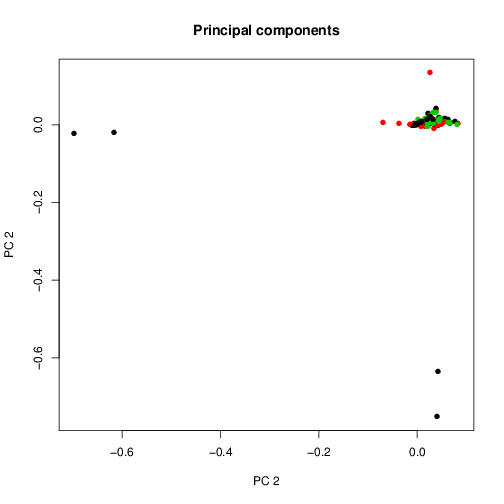

In [5]:
from wand.image import Image as WImage
img = WImage(filename='/local/home/sarahgw/WGS/SNPS/All_mylu/genolike/Rplots2.pdf')
img

look for associations for each group.


In [ ]:
!awk {print} /local/home/sarahgw/WGS/Sequences/filelists/VT_pheno.ybin

In [ ]:
!wc -l /local/home/sarahgw/WGS/Sequences/filelists/NJ_pheno.ybin

In [ ]:
/local/home/sarahgw/angsd/angsd -yBin /local/home/sarahgw/WGS/Sequences/filelists/VT_pheno.ybin -doAsso 1 -GL 1 -out VT_assoc -doMajorMinor 1 -doMaf 1 -minQ 20 -minMapQ 30 -SNP_pval 1e-6 -bam /local/home/sarahgw/WGS/Sequences/filelists/VT.filelist -P 15; echo "VT Assoc done amphiprion" | mailx gw.sarah@gmail.com

ok so if this is true:
The likelihood ratio statistic. This statistic is chi square distributed with one degree of freedom
Then that means p less than 0.05 is greater than 3.84

Right, but you need to do a p adjustment to deal with false positives. Ok, so let's take it into R and calculate p value and correct. 
Wait, maybe this is already accounting for false positives, paper seems to indicate that, no mention of correcting? Oh, so for standard GWAS there is a set significance thresholde of 5 x 10 ^ -8

In [ ]:
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_assoc.lrt0.gz
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_assoc.mafs.gz
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/NY_assoc.lrt0.gz
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/VT_assoc.lrt0.gz